In [109]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [110]:
#Download dataset
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 98% 145M/149M [00:00<00:00, 177MB/s]
100% 149M/149M [00:00<00:00, 175MB/s]


In [111]:
def get_class_path(path):
  classes=[]
  class_paths=[]

  # iterate through training directories
  for label in os.listdir(path):
    label_path=os.path.join(path,label)

    #check if it's a directory
    if os.path.isdir(label_path):
      #iterate through images
      for image in os.listdir(label_path):
        image_path=os.path.join(label_path,image)

        #add class and path to respective lists
        classes.append(label)
        class_paths.append(image_path)

  df=pd.DataFrame({
      'Class':classes,'Class_Path':class_paths})
  return df

In [112]:
# training set
tr_df=get_class_path("/content/Training")

# testing set
ts_df=get_class_path("/content/Testing")

In [113]:
tr_df

,Class,Class_Path
0,notumor,/content/Training/notumor/Tr-no_0794.jpg
1,notumor,/content/Training/notumor/Tr-no_1039.jpg
2,notumor,/content/Training/notumor/Tr-no_0972.jpg
3,notumor,/content/Training/notumor/Tr-no_0559.jpg
4,notumor,/content/Training/notumor/Tr-no_1252.jpg
...,...,...
5707,glioma,/content/Training/glioma/Tr-gl_0255.jpg
5708,glioma,/content/Training/glioma/Tr-gl_0182.jpg
5709,glioma,/content/Training/glioma/Tr-gl_0553.jpg
5710,glioma,/content/Training/glioma/Tr-gl_0380.jpg


In [114]:
ts_df

,Class,Class_Path
0,notumor,/content/Testing/notumor/Te-no_0097.jpg
1,notumor,/content/Testing/notumor/Te-no_0301.jpg
2,notumor,/content/Testing/notumor/Te-noTr_0000.jpg
3,notumor,/content/Testing/notumor/Te-no_0222.jpg
4,notumor,/content/Testing/notumor/Te-no_0139.jpg
...,...,...
1306,glioma,/content/Testing/glioma/Te-gl_0280.jpg
1307,glioma,/content/Testing/glioma/Te-gl_0163.jpg
1308,glioma,/content/Testing/glioma/Te-gl_0194.jpg
1309,glioma,/content/Testing/glioma/Te-gl_0146.jpg


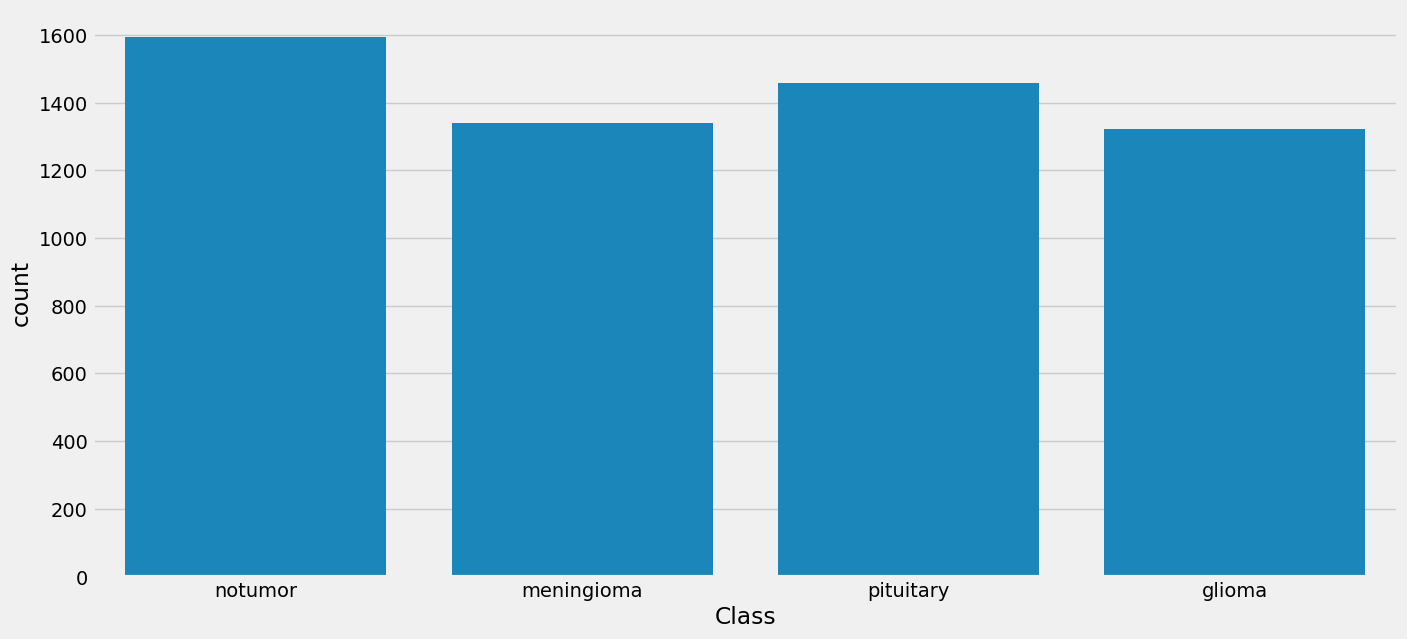

In [115]:
plt.figure(figsize=(15,7))
ax=sns.countplot(x=tr_df["Class"],data=tr_df)
# visualize data and see if it is balanced

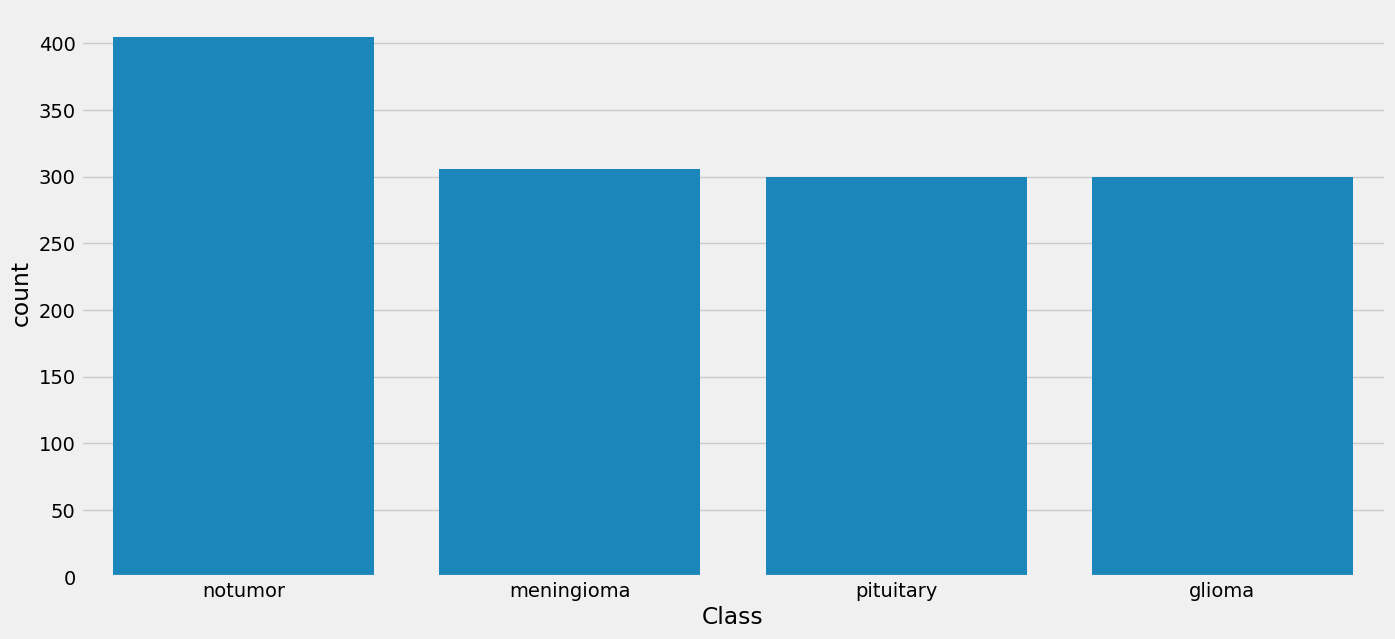

In [116]:
plt.figure(figsize=(15,7))
ax=sns.countplot(x=ts_df["Class"],data=ts_df)
# visualize data and see if it is balanced

In [117]:
# split dataset into training, testing, and validation sets (validate accuracy)

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision,Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [119]:
# split testing dataset into validation and testing set - crucial for tuning the model and preventing over-fitting
# By setting stratify=ts_df['Class'], train_test_split will split the data in a way that preserves the ratio of each class label in both the val_df and ts_df subsets. For example, if 30% of your data belongs to Class A and 70% belongs to Class B in the original dataset, the split datasets will have a similar distribution.
val_df,ts_df=train_test_split(ts_df,test_size=0.5,stratify=ts_df['Class'],random_state=42)

In [120]:
val_df


,Class,Class_Path
237,notumor,/content/Testing/notumor/Te-no_0027.jpg
434,meningioma,/content/Testing/meningioma/Te-me_0069.jpg
170,notumor,/content/Testing/notumor/Te-no_0394.jpg
1169,glioma,/content/Testing/glioma/Te-gl_0253.jpg
696,meningioma,/content/Testing/meningioma/Te-me_0186.jpg
...,...,...
582,meningioma,/content/Testing/meningioma/Te-me_0212.jpg
1138,glioma,/content/Testing/glioma/Te-gl_0193.jpg
1120,glioma,/content/Testing/glioma/Te-gl_0195.jpg
158,notumor,/content/Testing/notumor/Te-no_0081.jpg


In [121]:
ts_df

,Class,Class_Path
507,meningioma,/content/Testing/meningioma/Te-me_0292.jpg
455,meningioma,/content/Testing/meningioma/Te-me_0128.jpg
360,notumor,/content/Testing/notumor/Te-no_0098.jpg
590,meningioma,/content/Testing/meningioma/Te-me_0276.jpg
1051,glioma,/content/Testing/glioma/Te-gl_0249.jpg
...,...,...
72,notumor,/content/Testing/notumor/Te-no_0280.jpg
833,pituitary,/content/Testing/pituitary/Te-pi_0203.jpg
111,notumor,/content/Testing/notumor/Te-no_0313.jpg
625,meningioma,/content/Testing/meningioma/Te-me_0278.jpg


In [122]:
# preprocess data
batch_size=32 #can try 16, 64, 128 and see which results in the best performance

# resize all images to the same size to ensure they have the same dimensions
img_size=(299,299)

# create image data generator - rescaling image pixel values and adjusting brightness
image_generator=ImageDataGenerator(
    rescale=1/255, # In digital images, pixel values typically range from 0 to 255, where 0 represents black and 255 represents white. Dividing by 255 scales these values to a range between 0 and 1, which is a common preprocessing step that makes the data easier to work with for neural networks. Smaller values reduce the likelihood of issues like exploding gradients during training.
    brightness_range=(0.8,1.2) # brightness_range=(0.8, 1.2): This parameter adjusts the brightness of the images by applying a random scaling factor between 0.8 and 1.2. A brightness factor of 0.8 will make the image 20% darker, while a factor of 1.2 will make it 20% brighter. Random brightness adjustments increase the diversity of the training data, helping the model to generalize better by simulating variations in lighting conditions.

)

# For the testing dataset, we only rescale the images but not adjust the brightness because we want to keep it consistent and not have random brightness
ts_gen=ImageDataGenerator(rescale=1/255)

In [123]:
# create 3 data flows - training , validation, testing
tr_gen=image_generator.flow_from_dataframe(
    tr_df,
    x_col='Class_Path',
    y_col='Class',
    target_size=img_size,
    batch_size=batch_size)

valid_gen=image_generator.flow_from_dataframe(
    val_df,
    x_col='Class_Path',
    y_col='Class',
    target_size=img_size,
    batch_size=batch_size)

ts_gen=ts_gen.flow_from_dataframe(
    ts_df,
    x_col='Class_Path',
    y_col='Class',
    target_size=img_size,
    batch_size=16,
    shuffle=False)


Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


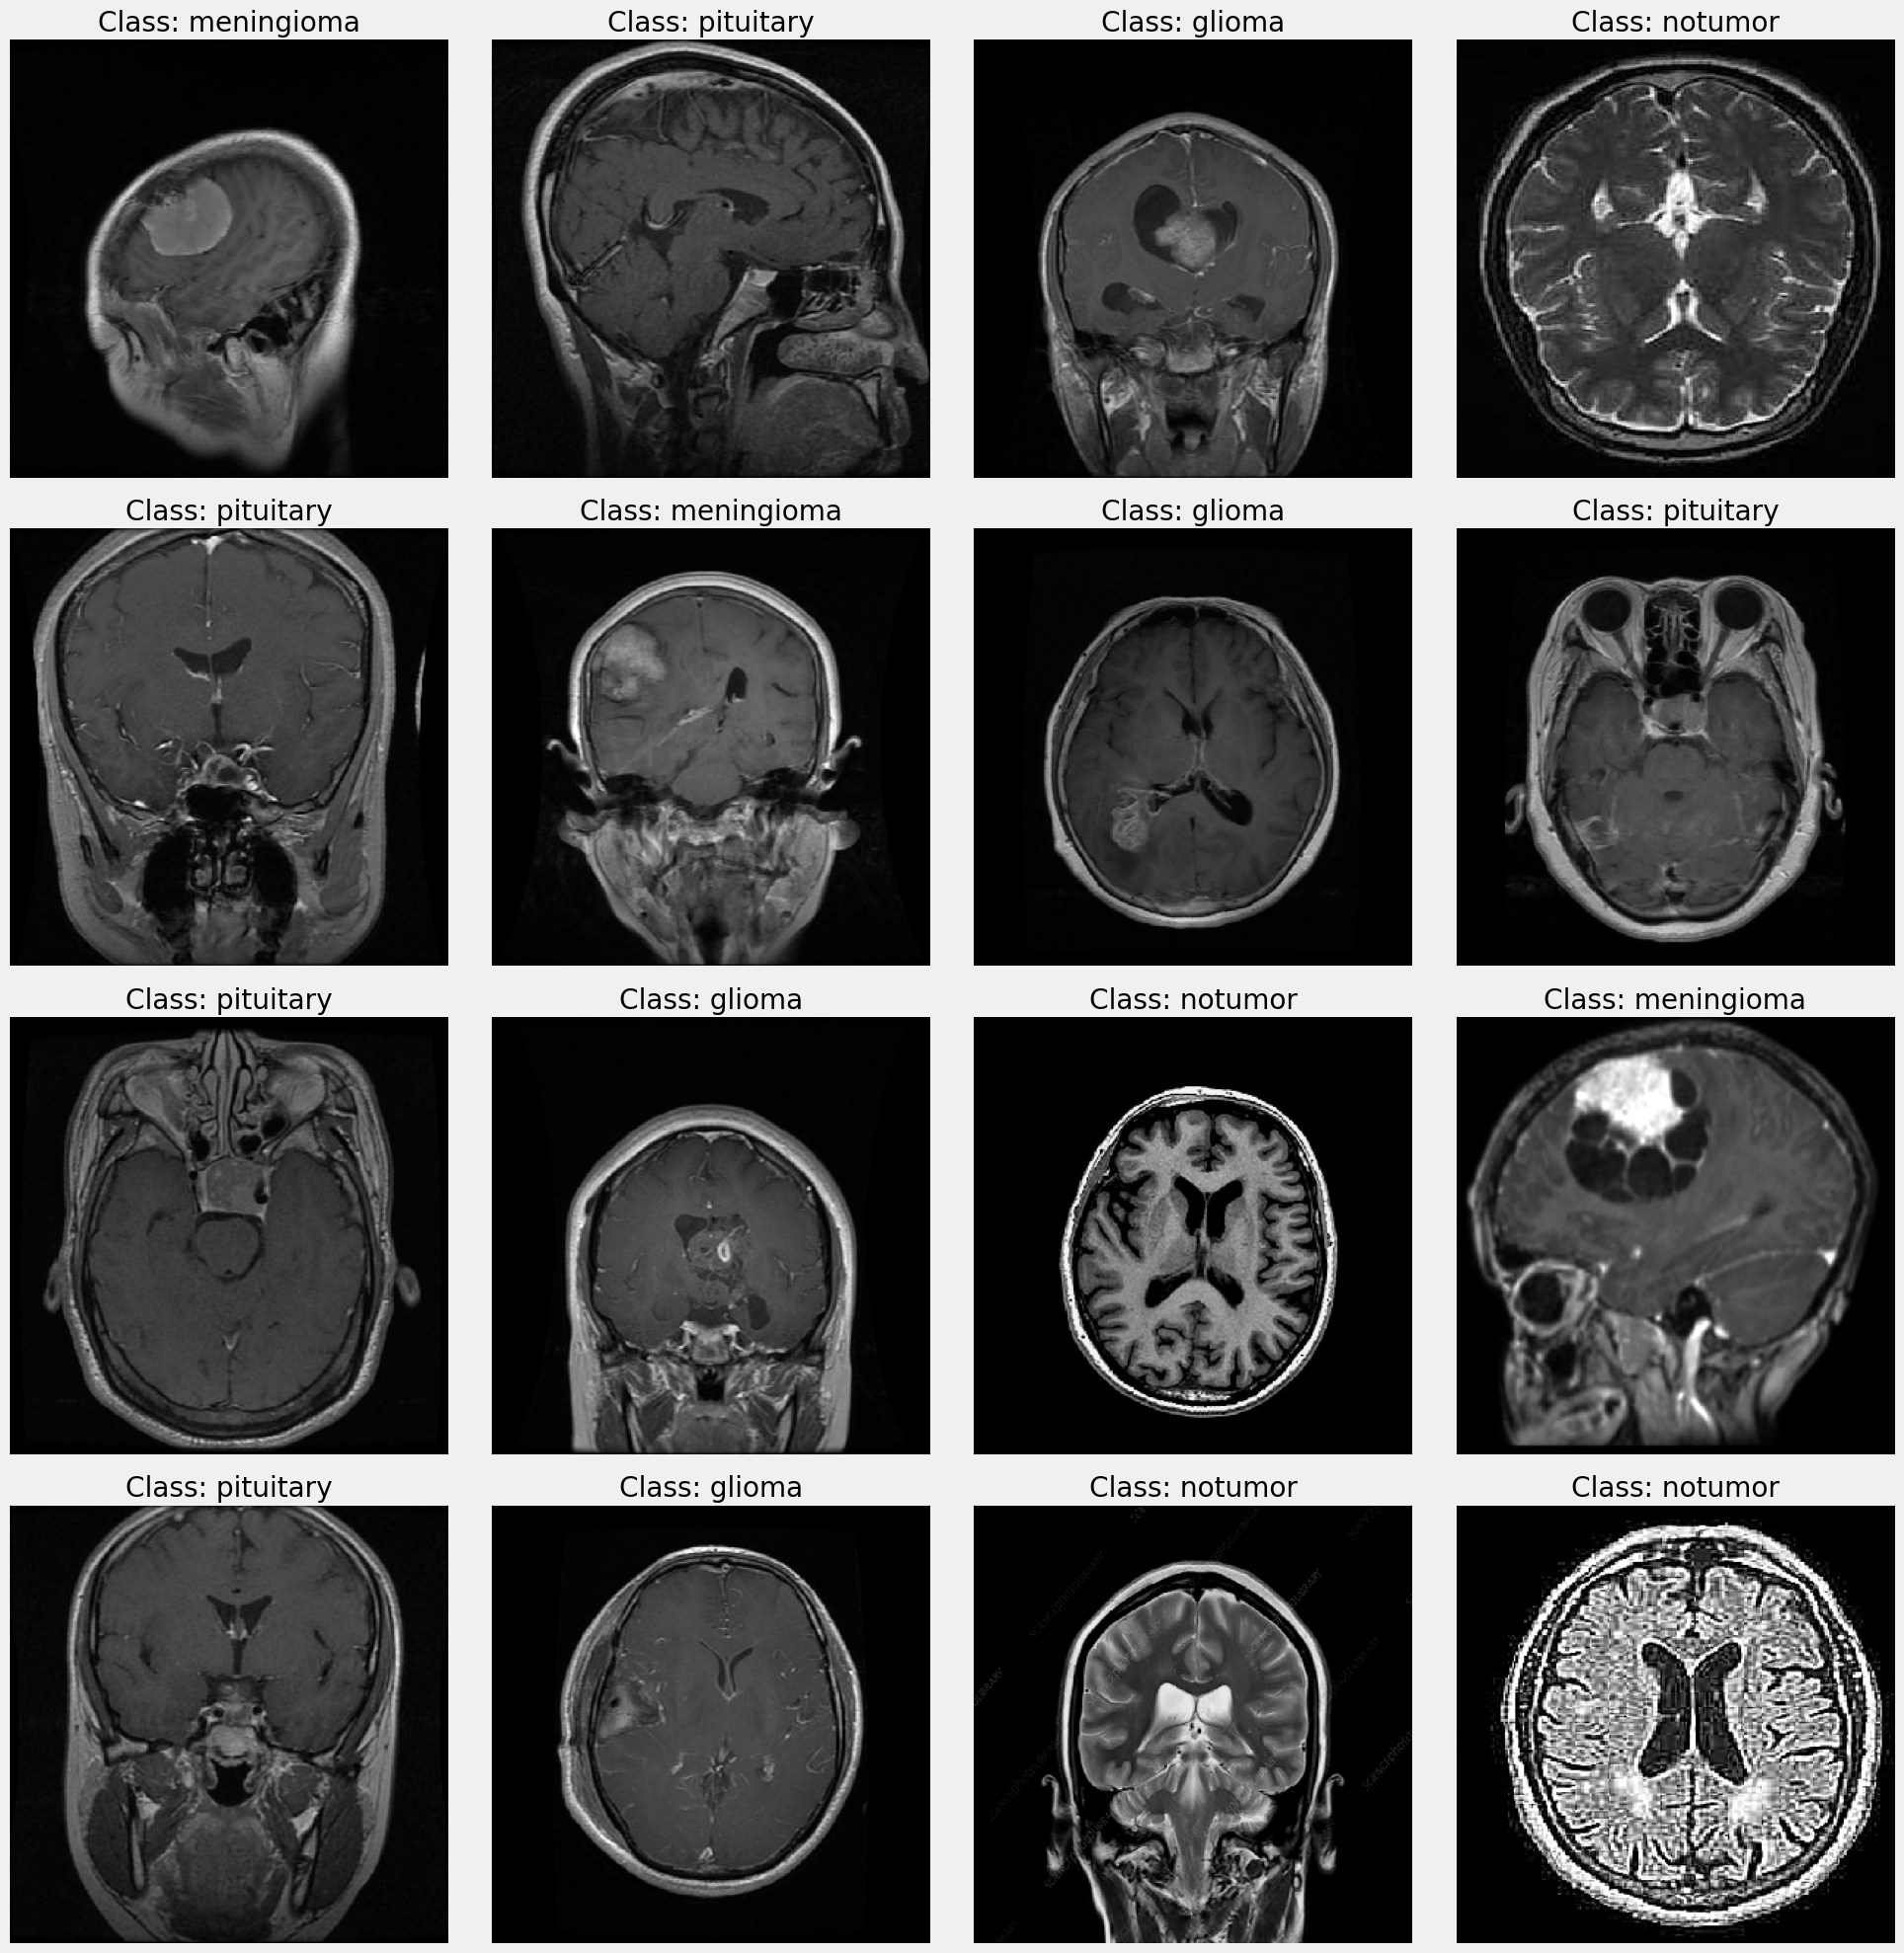

In [124]:
plt.figure(figsize=(20,20))

for i in range(16):
  plt.subplot(4,4,i+1)
  batch=next(tr_gen) #retrieves the next batch of images and labels from tr_gen

  image=batch[0][0]
  label=batch[1][0]
  plt.imshow(image) #Displays the extracted image in the current subplot.

  # get the class index
  class_index=np.argmax(label)

  # get the list of class names and class indices
  class_names=list(tr_gen.class_indices.keys()) # retrieves a list of class names from the generator.
  class_indices=list(tr_gen.class_indices.values()) #retrieves a list of class indices from the generator, matching each class to its index.

  # find the index of the class_index in the list of indices
  index_position=class_indices.index(class_index)

  # get the class name from the class index
  class_name=class_names[index_position]

  plt.title(f"Class: {class_name}")
  plt.axis('off')
plt.tight_layout()
plt.show()


In [125]:
# Xception Model
# training process:
# The model was shown millions of images from the ImageNet dataset,
# and for each image, it was told what the object in the image was
# Over time, Xception learned the patterns and features that distinguish different objects (like the stripes of a tiger, or the circular shape of a car's tire).
# The training process involves a lot of trial and error.
# In the beginning, the model might make mistakes, but after each mistake, it adjusts (or learns) a little bit to improve its accuracy. This is done using a process called backpropagation and optimization techniques like Stochastic Gradient Descent (SGD).



In [126]:
image_shape=(299,299,3) # size of 299x299, 3 represents RGB color format red, green, blue

# include_top=False: exclude the final classification layers, leaving only the convolutional base
# This is useful for using Xception for feature extraction rather than for direct classification, allowing you to add your own custom layers for a specific task.

# weights='imagenet': The model’s weights are pre-trained on the ImageNet dataset
# pooling='max': Smart summarizer for image data. It focuses on the most important features in the image.
# It works by looking at small sections of the image one at a time, keeping only the most standout pixel, which is the one with the highest value from each section of the image
# This proces helps out model by reducing the amount of information to process, making it faster and more efficient while retaining the most crucial details for identifying things like tumors in the brain scans.

base_model=tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=image_shape,
    pooling='max'
)

# define a sequential model: it takes the Xception model (base_model) and add a few layers that take the output from the Xception model and transform it into the final predictions - different types of tumors


model=Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3), #prevent overfitting: when the model learns the training data too well, and it performs poorly on new and unseen data. this layer randomly drops out some neurons to help the model generalize better to new data
    Dense(128,activation='relu'), # take the output from the previous layer and transform it into the final predictions
    Dropout(rate=0.25),
    Dense(4,activation='softmax')
])

#

In [127]:
#model compling
model.compile(Adamax(learning_rate=0.001), # Adamax helps model learn by adjusting how big of a step it takes when it's updating its knowledge and the weights of the model
              # adamax helps you decide how big your steps should be if you are far from the lowest , bigger when far smaller when close
              # it also remembers which direction you worked well before to help you move more efficient
              loss='categorical_crossentropy', # often used in classification tasks, indicate how much the predicted probabilities defer from the actual probabilities of each class in the dataset
              metrics=['accuracy',
                       Precision(), #percentage of true positives
                       Recall()]) #percentage of true positives that were correctly predicted

#learning rate: low learning rate means the model takes smaller steps when updating its weights, so it learns slowly but more accurately

# it's trying to find the lowest loss and the loss function is a difference between the predicted output and actual output
# so when the model is being trained there's a loss calculated for each image in the dataset
# the loss is equal to zero when the predicted output is exactly the same as the actual output
# the loss will be higher when the predicted output is different from the actual output
# so this optimizer adjusts the weights of the model to make the predicted output closer to the actual output

# the higher the loss the worse the prediction
# calculate losses - adjust weights - repeat the process to improve model

In [128]:
hist=model.fit(tr_gen,
               epochs=5, #the model will go through the entire training dataset 5 times, the model will make 5 passes over the training dat and for each pass it will update the model's weights based on loss and other metrics
               validation_data=valid_gen,
               )

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 210s 956ms/step - accuracy: 0.6795 - loss: 0.9281 - precision_2: 0.7855 - recall_2: 0.5190 - val_accuracy: 0.9298 - val_loss: 0.1914 - val_precision_2: 0.9339 - val_recall_2: 0.9282
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 163s 835ms/step - accuracy: 0.9576 - loss: 0.1199 - precision_2: 0.9604 - recall_2: 0.9560 - val_accuracy: 0.9160 - val_loss: 0.2668 - val_precision_2: 0.9173 - val_recall_2: 0.9145
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 150s 829ms/step - accuracy: 0.9908 - loss: 0.0313 - precision_2: 0.9910 - recall_2: 0.9907 - val_accuracy: 0.9710 - val_loss: 0.0691 - val_precision_2: 0.9710 - val_recall_2: 0.9710
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 203s 837ms/step - accuracy: 0.9942 - loss: 0.0188 - precision_2: 0.9944 - recall_2: 0.9939 - val_accuracy: 0.9771 - val_loss: 0.0840 - val_precision_2: 0.9771 - val_recall_2: 0.9771
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 150s 831ms/step - accuracy: 0.9948 - loss: 0.0164 - precision_2: 0.9956 - recall_2: 0.9

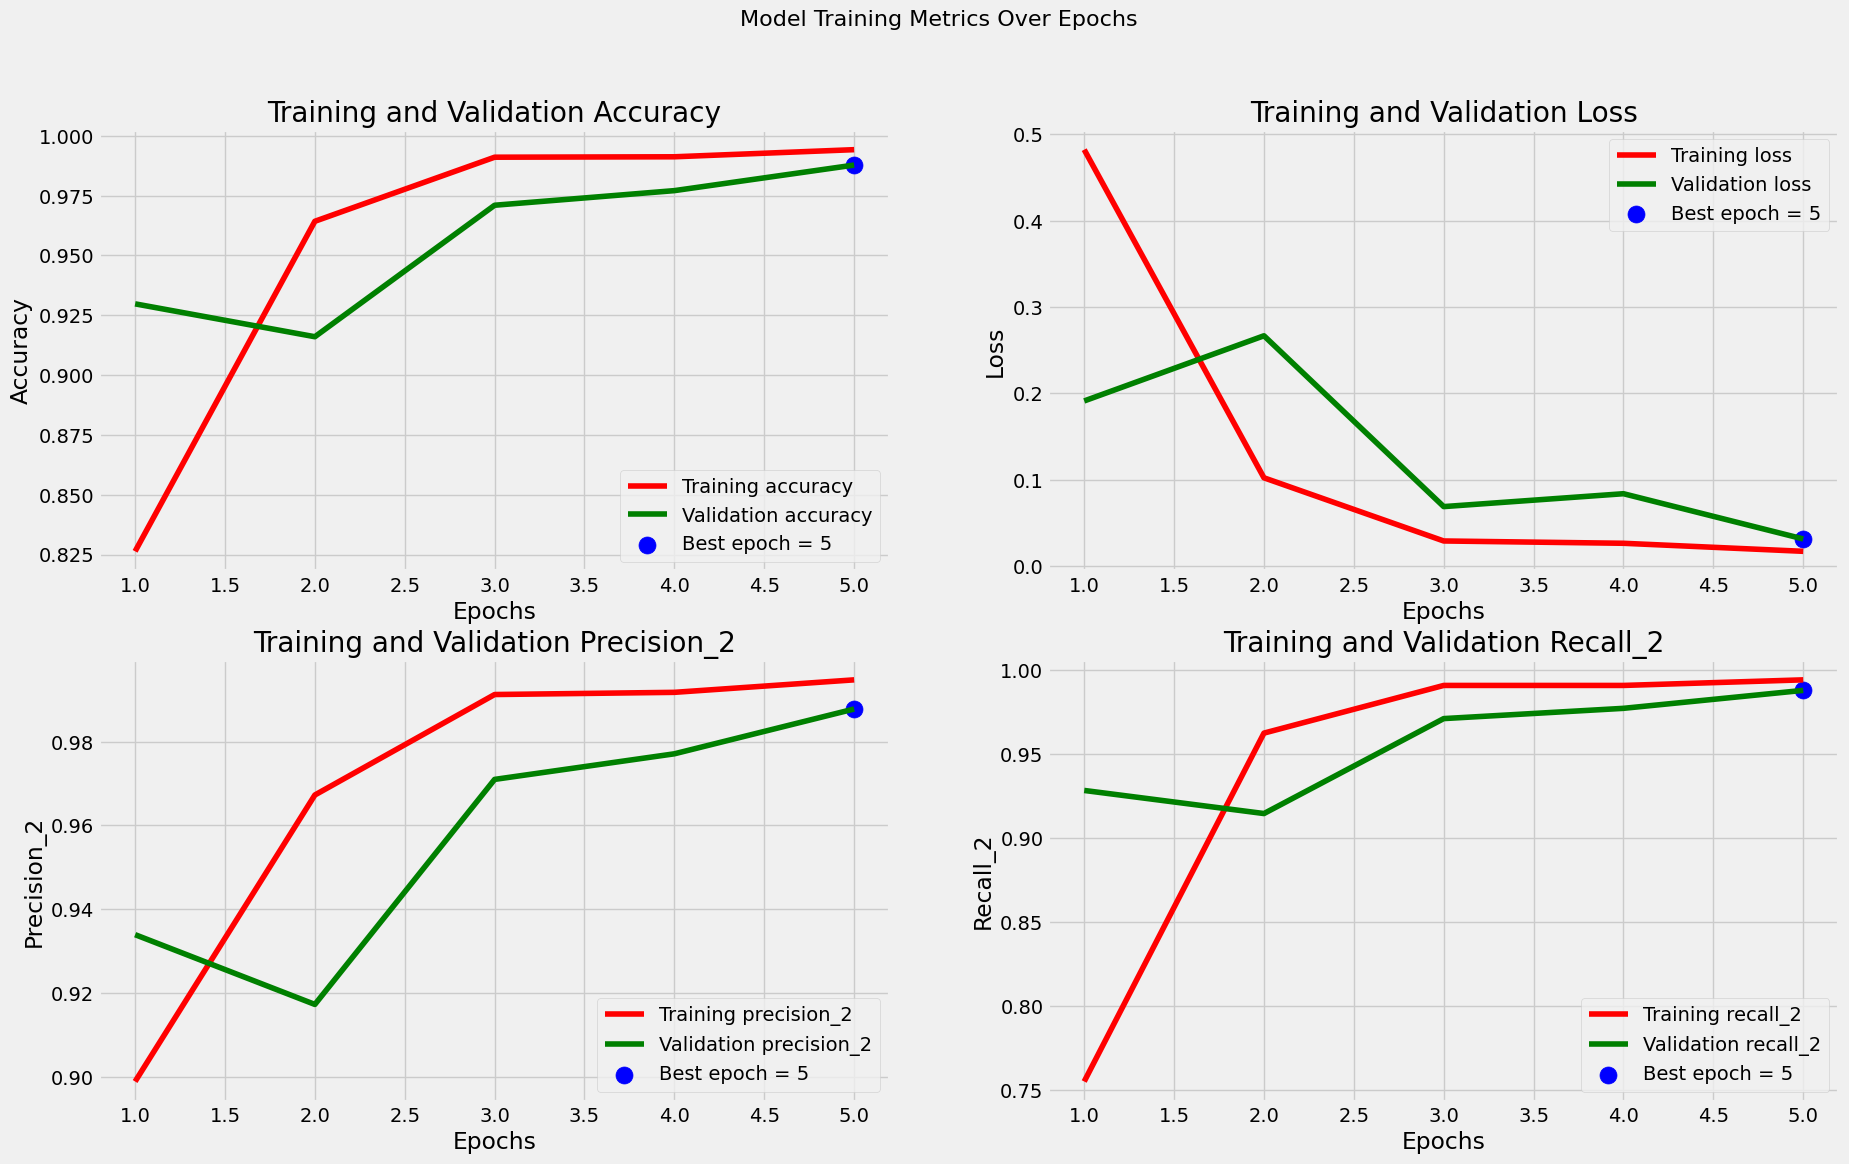

In [137]:
# Get training and validation metrics from history
metrics = ['accuracy', 'loss', 'precision_2', 'recall_2']

tr_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f'val_{m}'] for m in metrics}

# Find best epochs and values
best_epochs = {}
best_values = {}

for m in metrics:
  if m == 'loss':
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m])

  best_epochs[m] = idx + 1
  best_values[m] = val_metrics[m][idx]

# Plot metrics
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

for i,metric in enumerate(metrics,1):
  plt.subplot(2, 2, i)
  epochs=range(1,len(tr_metrics[metric])+1)

  plt.plot(epochs,tr_metrics[metric],'r', label=f'Training {metric}')
  plt.plot(epochs,val_metrics[metric],'g', label=f'Validation {metric}')
  plt.scatter(best_epochs[metric],best_values[metric],s=150,c='blue',
              label=f'Best epoch = {best_epochs[metric]}')
  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [138]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}")

print(f"\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")

print(f"\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")


179/179 ━━━━━━━━━━━━━━━━━━━━ 47s 262ms/step - accuracy: 0.9985 - loss: 0.0052 - precision_2: 0.9985 - recall_2: 0.9985
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - accuracy: 0.9858 - loss: 0.0355 - precision_2: 0.9858 - recall_2: 0.9858
 1/41 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - accuracy: 0.9375 - loss: 0.0771 - precision_2: 0.9375 - recall_2: 0.9375

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9807 - loss: 0.0503 - precision_2: 0.9816 - recall_2: 0.9765
Train Accuracy: 99.84%
Train Loss: 0.0050

Validation Accuracy: 98.63%
Validation Loss: 0.0336

Test Accuracy: 98.63%
Test Loss: 0.0361


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step


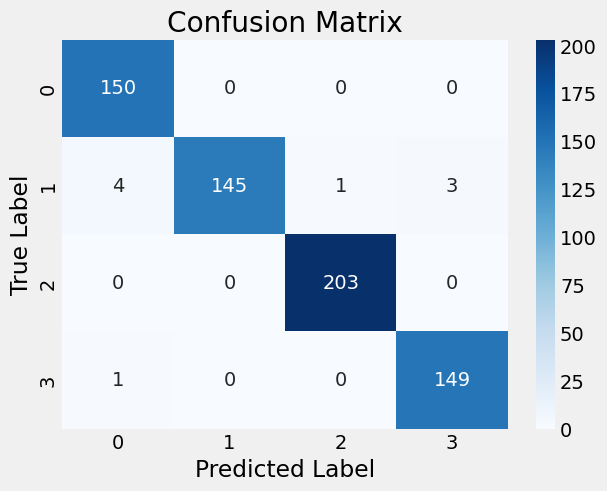

In [139]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'no_tumor',
    3: 'pituitary'
}
labels = list(class_dict.keys())

# Then create and display the confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [140]:
from PIL import Image

def predict(img_path: str) -> None:
    # Get class labels
    labels = list(class_dict.keys())

    # Create figure
    plt.figure(figsize=(6, 8))

    # Load and preprocess image
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img_array = np.asarray(resized_img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Get model predictions
    predictions = model.predict(img_array)
    probabilities = list(predictions[0])

    # Get predicted class
    predicted_class_idx = np.argmax(probabilities)
    predicted_class = class_dict[predicted_class_idx]

    # Plot original image
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.title(f"Input MRI Image\nPredicted: {predicted_class}")

    # Plot prediction probabilities
    plt.subplot(2, 1, 2)
    bars = plt.bar(labels, probabilities)
    plt.xlabel("Class Probability", fontsize=15)
    plt.title("Class Probabilities")

    # Add probability labels to bars
    ax = plt.gca()
    ax.bar_label(bars, fmt="%.2f")

    plt.tight_layout()
    plt.show()

    print(f"\nPredicted tumor type: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


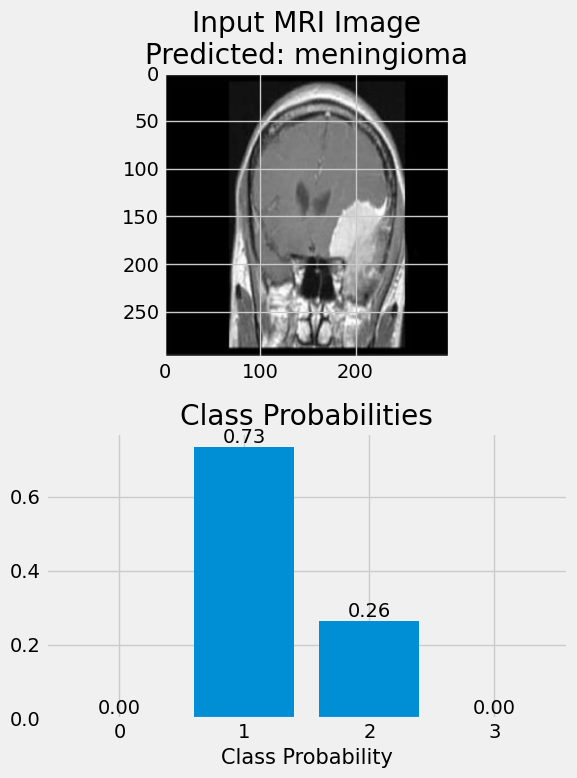


Predicted tumor type: meningioma


In [141]:
predict("/content/Testing/meningioma/Te-meTr_0000.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


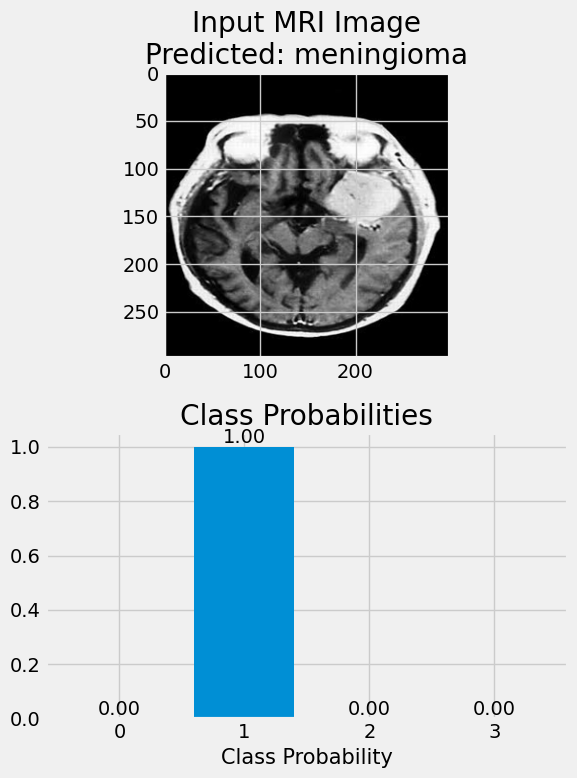


Predicted tumor type: meningioma


In [142]:
predict("/content/Testing/meningioma/Te-meTr_0005.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


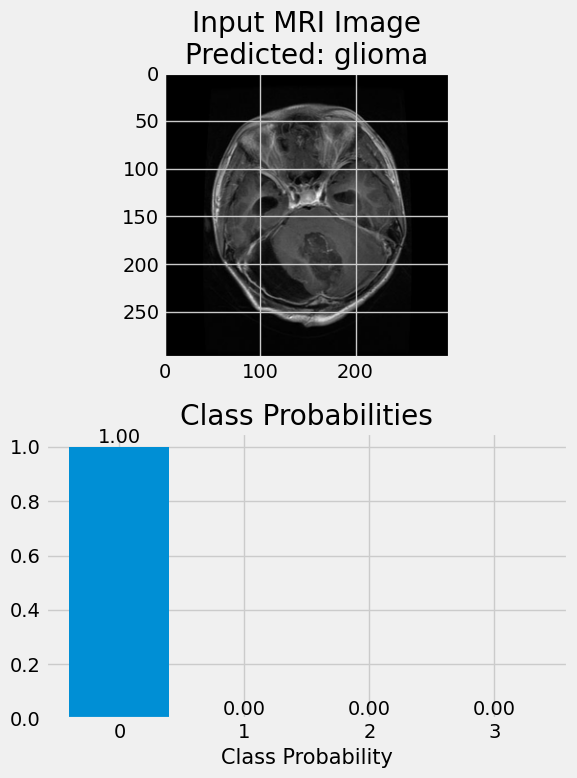


Predicted tumor type: glioma


In [143]:
predict("/content/Testing/glioma/Te-glTr_0000.jpg")

In [ ]:
model.save_weights('xception_model.weights.h5')

In [146]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

batch_size = 16
img_size = (224, 224)

image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))
ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen=image_generator.flow_from_dataframe(
    tr_df,
    x_col='Class_Path',
    y_col='Class',
    target_size=img_size,
    batch_size=batch_size)

valid_gen=image_generator.flow_from_dataframe(
    val_df,
    x_col='Class_Path',
    y_col='Class',
    target_size=img_size,
    batch_size=batch_size)

ts_gen=ts_gen.flow_from_dataframe(
    ts_df,
    x_col='Class_Path',
    y_col='Class',
    target_size=img_size,
    batch_size=16,
    shuffle=False)


Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [147]:
# Create a Sequential model
cnn_model = Sequential()

# Convolutional layers
cnn_model.add(Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

# Flatten the output for fully connected layers
cnn_model.add(Flatten())

# Fully connected layers
cnn_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(Dropout(0.35))

cnn_model.add(Dense(4, activation='softmax'))  # Output layer with 4 neurons for the 4 classes

# Compile the model
cnn_model.compile(Adamax(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])

# Display the model summary
cnn_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 112, 112, 256)       │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 56, 56, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,656,260 (13.95 MB)

 Trainable params: 3,656,260 (13.95 MB)

 Non-trainable params: 0 (0.00 B)

In [148]:
history=cnn_model.fit(tr_gen,
               epochs=5,
               validation_data=valid_gen,
               )

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 44s 95ms/step - accuracy: 0.5473 - loss: 2.6426 - precision_3: 0.6652 - recall_3: 0.3405 - val_accuracy: 0.7405 - val_loss: 1.0415 - val_precision_3: 0.7755 - val_recall_3: 0.6962
Epoch 2/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 71s 86ms/step - accuracy: 0.7864 - loss: 0.8799 - precision_3: 0.8136 - recall_3: 0.7509 - val_accuracy: 0.7786 - val_loss: 0.7753 - val_precision_3: 0.8081 - val_recall_3: 0.7008
Epoch 3/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.8331 - loss: 0.6420 - precision_3: 0.8541 - recall_3: 0.8045 - val_accuracy: 0.8183 - val_loss: 0.6026 - val_precision_3: 0.8304 - val_recall_3: 0.7924
Epoch 4/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.8609 - loss: 0.5329 - precision_3: 0.8730 - recall_3: 0.8413 - val_accuracy: 0.8061 - val_loss: 0.5634 - val_precision_3: 0.8220 - val_recall_3: 0.7969
Epoch 5/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.8868 - loss: 0.4669 - precision_3: 0.8966 - recall_3: 0.8745 - val_

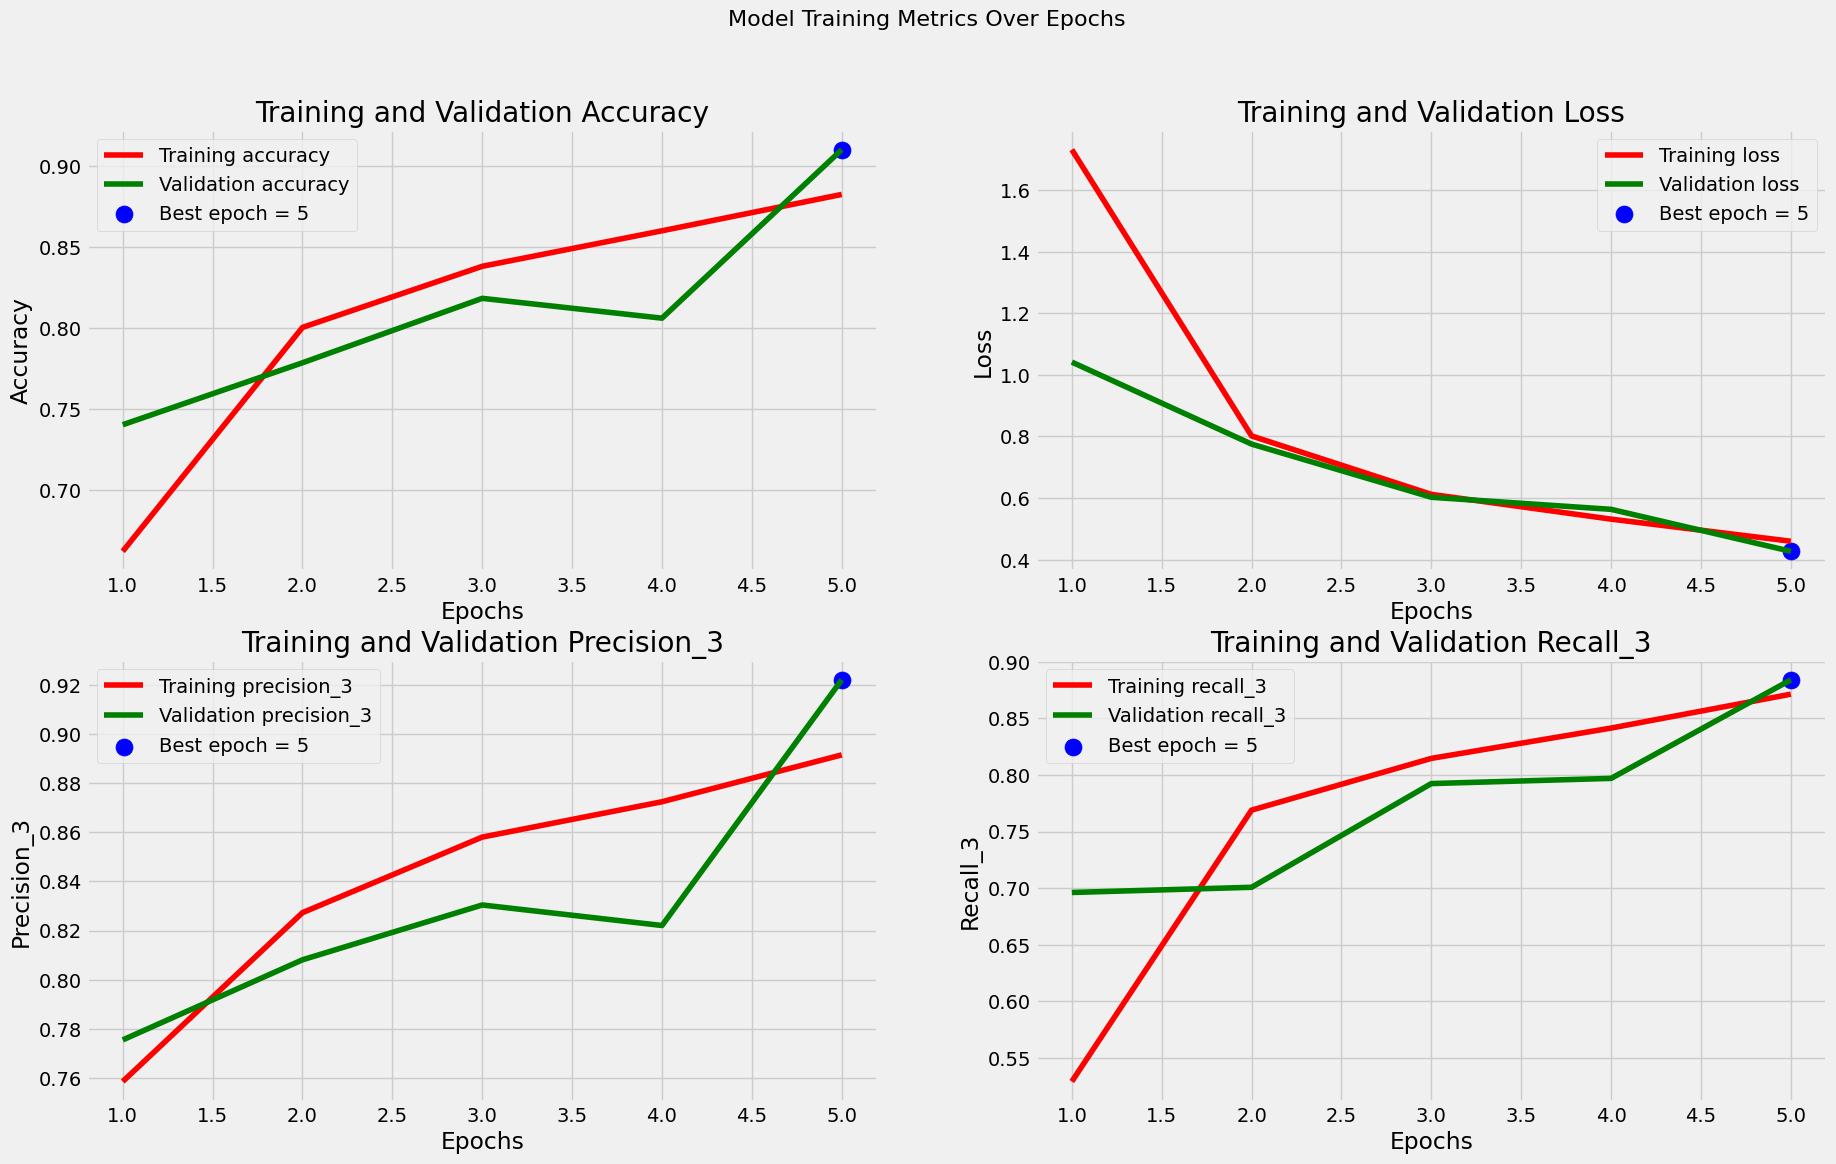

In [150]:
# Get training and validation metrics from history
metrics = ['accuracy', 'loss', 'precision_3', 'recall_3']
tr_metrics = {m: history.history[m] for m in metrics}
val_metrics = {m: history.history[f'val_{m}'] for m in metrics}

# Find best epochs and values
best_epochs = {}
best_values = {}

for m in metrics:
  if m == 'loss':
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m])

  best_epochs[m] = idx + 1
  best_values[m] = val_metrics[m][idx]

# Plot metrics
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

for i,metric in enumerate(metrics,1):
  plt.subplot(2, 2, i)
  epochs=range(1,len(tr_metrics[metric])+1)

  plt.plot(epochs,tr_metrics[metric],'r', label=f'Training {metric}')
  plt.plot(epochs,val_metrics[metric],'g', label=f'Validation {metric}')
  plt.scatter(best_epochs[metric],best_values[metric],s=150,c='blue',
              label=f'Best epoch = {best_epochs[metric]}')
  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [151]:
train_score = cnn_model.evaluate(tr_gen, verbose=1)
valid_score = cnn_model.evaluate(valid_gen, verbose=1)
test_score = cnn_model.evaluate(ts_gen, verbose=1)

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}")

print(f"\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")

print(f"\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")


357/357 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - accuracy: 0.9376 - loss: 0.3697 - precision_3: 0.9470 - recall_3: 0.9233
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8698 - loss: 0.4715 - precision_3: 0.8882 - recall_3: 0.8506
 2/41 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7969 - loss: 0.6216 - precision_3: 0.7969 - recall_3: 0.7969

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8581 - loss: 0.5227 - precision_3: 0.8672 - recall_3: 0.8428
Train Accuracy: 93.24%
Train Loss: 0.3754

Validation Accuracy: 89.47%
Validation Loss: 0.4366

Test Accuracy: 87.50%
Test Loss: 0.4821


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


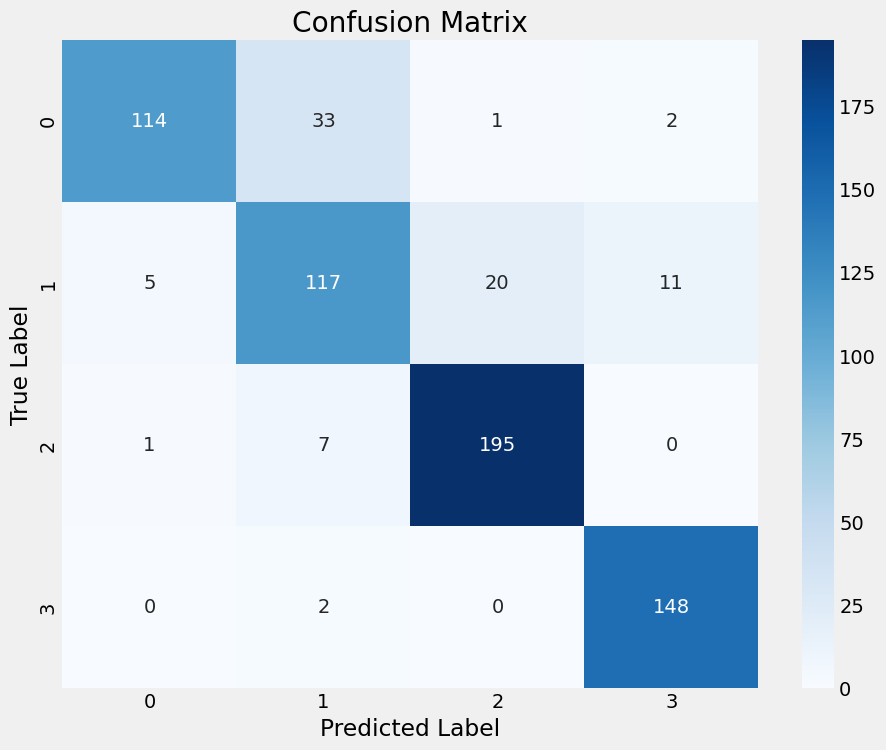

In [152]:
preds = cnn_model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'no_tumor',
    3: 'pituitary'
}

# Then create and display the confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [153]:
clr=classification_report(ts_gen.classes,y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.95      0.76      0.84       150
           1       0.74      0.76      0.75       153
           2       0.90      0.96      0.93       203
           3       0.92      0.99      0.95       150

    accuracy                           0.88       656
   macro avg       0.88      0.87      0.87       656
weighted avg       0.88      0.88      0.87       656



In [ ]:
cnn_model.save_weights('cnn_model.h5')

Streamlit App

In [155]:
! pip install streamlit pyngrok python-dotenv

In [156]:
from threading import Thread
from pyngrok import ngrok
from google.colab import userdata

In [157]:
ngrok_token=userdata.get('NGROK_AUTH_TOKEN')
ngrok.set_auth_token(ngrok_token)

In [158]:
def run_streamlit():
    os.system("streamlit run /content/app.py --server.port 8501")

In [182]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import plotly.graph_objects as go
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
import google.generativeai as genai
from google.colab import userdata
import PIL.Image
import os
from google.colab import userdata
from dotenv import load_dotenv
load_dotenv()

genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))

output_dir = 'saliency_maps'
os.makedirs(output_dir, exist_ok=True)

def generate_explanation(img_path, model_prediction, confidence):
    prompt = f"""You are an expert neurologist. You are tasked with explaining a saliency map of a brain tumor MRI scan.
    The saliency map was generated by a deep learning model that was trained to classify brain tumors
    as either glioma, meningioma, pituitary, or no tumor.

    The saliency map highlights the regions of the image that the machine learning model is focusing on to make the prediction.

    The deep learning model predicted the image to be of class '{model_prediction}' with a confidence of {confidence * 100}%.

    In your response:
    - Explain what regions of the brain the model is focusing on, based on the saliency map. Refer to the regions highlighted
      in light cyan, those are the regions where the model is focusing on.
    - Explain possible reasons why the model made the prediction it did.
    - Don't mention anything like 'The saliency map highlights the regions the model is focusing on, which are in light cyan'
      in your explanation.
    - Keep your explanation to 4 sentences max.
    """
    img = PIL.Image.open(img_path)

    model = genai.GenerativeModel(model_name="gemini-1.5-flash")
    response = model.generate_content([prompt, img])

    return response.text


def generate_saliency_map(model, img_array, class_index, img_size):
    with tf.GradientTape() as tape:
        img_tensor = tf.convert_to_tensor(img_array)
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        target_class = predictions[:, class_index]
    gradients = tape.gradient(target_class, img_tensor)
    gradients = tf.math.abs(gradients)
    gradients = tf.reduce_max(gradients, axis=-1)
    gradients = gradients.numpy().squeeze()

    # Resize gradients to match original image size
    gradients = cv2.resize(gradients, img_size)

    # Create a circular mask for the brain area
    center = (gradients.shape[0] // 2, gradients.shape[1] // 2)
    radius = min(center[0], center[1]) - 10
    y, x = np.ogrid[:gradients.shape[0], :gradients.shape[1]]
    mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2

    # Apply mask to gradients
    gradients = gradients * mask

    # Normalize only the brain area
    brain_gradients = gradients[mask]
    if brain_gradients.max() > brain_gradients.min():
        brain_gradients = (brain_gradients - brain_gradients.min()) / (brain_gradients.max() - brain_gradients.min())
    gradients[mask] = brain_gradients

    # Apply a higher threshold
    threshold = np.percentile(gradients[mask], 80)
    gradients[gradients < threshold] = 0

    # Apply more aggressive smoothing
    gradients = cv2.GaussianBlur(gradients, (11, 11), 0)

    # Create a heatmap overlay with enhanced contrast
    heatmap = cv2.applyColorMap(np.uint8(255 * gradients), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match original image size
    heatmap = cv2.resize(heatmap, img_size)

    # Superimpose the heatmap on original image with increased opacity
    original_img = image.img_to_array(img)
    superimposed_img = heatmap * 0.7 + original_img * 0.3
    superimposed_img = superimposed_img.astype(np.uint8)

    img_path = os.path.join(output_dir, uploaded_file.name)
    with open(img_path, "wb") as f:
        f.write(uploaded_file.getbuffer())

    saliency_map_path = f'saliency_maps/{uploaded_file.name}'

    # Save the saliency map
    cv2.imwrite(saliency_map_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))

    return superimposed_img

def load_xception_model(model_path):
    img_shape = (299, 299, 3)
    base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet",
                                                input_shape=img_shape, pooling="max")

    model = Sequential([
        base_model,
        Flatten(),
        Dropout(rate=0.3),
        Dense(128, activation="relu"),
        Dropout(rate=0.25),
        Dense(4, activation="softmax")
    ])

    model.build((None,) + img_shape)

    # Compile the model
    model.compile(Adamax(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy",
                           Precision(),
                           Recall()])

    model.load_weights(model_path)

    return model


st.title("Brain Tumor Classification")
st.write("Upload an image of a brain MRI scan to classify.")

uploaded_file=st.file_uploader("Choose an image...",type=["jpg","jpeg","png"])

if uploaded_file is not None:
    selected_model = st.radio(
        "Select Model",
        ("Transfer Learning - Xception", "Custom CNN")
    )

    if selected_model == "Transfer Learning - Xception":
        model = load_xception_model('/content/xception_model.weights.h5')
        img_size = (299, 299)
    else:
        model = load_model('/content/cnn_model.h5')
        img_size = (224, 224)

    labels = ['Glioma', 'Meningioma', 'No tumor', 'Pituitary']
    img = image.load_img(uploaded_file, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)

    # Get the class with the highest probability
    class_index = np.argmax(prediction[0])
    result = labels[class_index]
    st.write(f"Predicted Class:{result}")
    st.write("Predictions:")
    for label, prob in zip(labels, prediction[0]):
        st.write(f"{label}: {prob:.4f}")

    saliency_map = generate_saliency_map(model, img_array, class_index, img_size)

    col1, col2 = st.columns(2)
    with col1:
      st.image(uploaded_file, caption='Uploaded Image', use_column_width=True)
    with col2:
      st.image(saliency_map, caption='Saliency Map', use_column_width=True)


    saliency_map_path = f'saliency_maps/{uploaded_file.name}'
    explanation = generate_explanation(saliency_map_path, result, prediction[0][class_index])
    st.write("## Explanation:")
    st.write(explanation)

    st.write("## Classification Results")

    result_container = st.container()
    result_container = st.container()
    result_container.markdown(
        f"""
        <div style="background-color: #000000; color: #ffffff; padding: 30px; border-radius: 15px;">
            <div style="display: flex; justify-content: space-between; align-items: center;">
                <div style="flex: 1; text-align: center;">
                    <h3 style="color: #ffffff; margin-bottom: 10px; font-size: 20px;">Prediction</h3>
                    <p style="font-size: 36px; font-weight: 800; color: #FF0000; margin: 0;">
                        {result}
                    </p>
                </div>
                <div style="width: 2px; height: 80px; background-color: #ffffff; margin: 0 20px;"></div>
                <div style="flex: 1; text-align: center;">
                    <h3 style="color: #ffffff; margin-bottom: 10px; font-size: 20px;">Confidence</h3>
                    <p style="font-size: 36px; font-weight: 800; color: #2196F3; margin: 0;">
                        {prediction[0][class_index]:.4f}
                    </p>
                </div>
            </div>
        </div>
        """,
        unsafe_allow_html=True
    )

    # Prepare data for Plotly chart
    probabilities = prediction[0]
    sorted_indices = np.argsort(probabilities)[::-1]
    sorted_labels = [labels[i] for i in sorted_indices]
    sorted_probabilities = probabilities[sorted_indices]

    # Create a Plotly bar chart
    fig = go.Figure(go.Bar(
        x=sorted_probabilities,
        y=sorted_labels,
        orientation='h',
        marker_color=['red' if label == result else 'blue' for label in sorted_labels]
    ))

    # Customize the chart layout
    fig.update_layout(
        title="Probabilities for each class",
        xaxis_title="Probability",
        yaxis_title="Class",
        height=400,
        width=600,
        yaxis=dict(autorange="reversed")
    )

    # Add value labels to the bars
    for i, prob in enumerate(sorted_probabilities):
        fig.add_annotation(
            x=prob,
            y=i,
            text=f"{prob:.4f}",
            showarrow=False,
            xanchor="left",
            xshift=5
        )

    # Display the Plotly chart
    st.plotly_chart(fig)

    saliency_map_path = f'saliency_maps/{uploaded_file.name}'
    explanation = generate_explanation(saliency_map_path, result, prediction[0][class_index])

    st.write("## Explanation")
    st.write(explanation)




Overwriting app.py


In [183]:
thread = Thread(target=run_streamlit)
thread.start()

In [184]:
public_url = ngrok.connect(addr='8501',proto="http",bind_tls=True)
print("Public URL:", public_url)

Public URL: NgrokTunnel: "https://8119-34-125-77-206.ngrok-free.app" -> "http://localhost:8501"


In [181]:
tunnels = ngrok.get_tunnels()
for tunnel in tunnels:
  ngrok.disconnect(tunnel.public_url)

Overwriting .env
